# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.266331,False,0.186198
1,-0.577283,False,-0.263693
2,-0.759739,True,3.956742
3,-0.158249,False,0.146362
4,0.129720,False,-0.781201
...,...,...,...
995,0.129913,False,-1.043541
996,-1.596959,False,-2.221180
997,-0.573585,False,-0.898515
998,-1.221957,False,-2.245137


<Axes: xlabel='v0'>

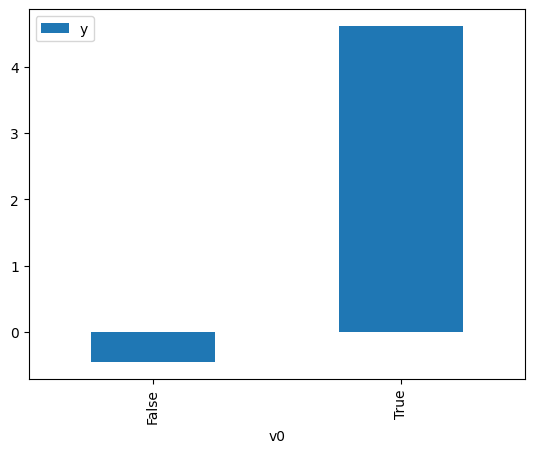

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

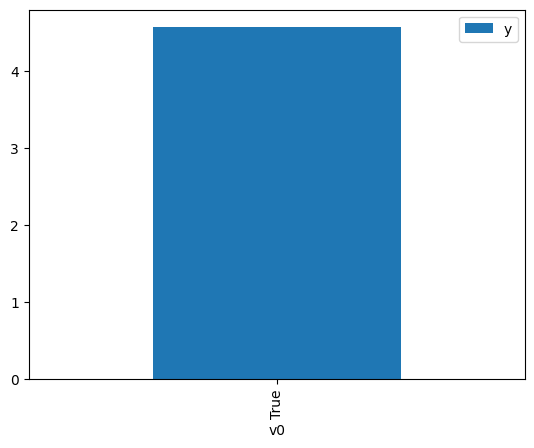

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.461199,False,-0.974013,0.859671,1.163236
1,-1.183711,False,-0.711176,0.812896,1.230169
2,-2.022528,False,-3.317512,0.924678,1.081458
3,1.225780,False,2.189129,0.180229,5.548483
4,-0.393947,False,-3.161741,0.620331,1.612041
...,...,...,...,...,...
995,-0.707376,False,0.270499,0.706632,1.415164
996,-0.728482,False,-0.762697,0.712021,1.404453
997,0.272532,False,1.806332,0.417180,2.397049
998,-1.728074,False,-0.945565,0.895017,1.117298


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.160562,True,3.561945,0.548771,1.822254
1,0.110464,True,4.816448,0.533368,1.874880
2,0.673347,True,6.475563,0.696503,1.435744
3,0.407568,True,6.274436,0.622831,1.605573
4,0.736094,True,4.870072,0.712673,1.403168
...,...,...,...,...,...
995,0.437025,True,5.410330,0.631361,1.583881
996,-2.089242,True,4.667029,0.069766,14.333545
997,0.256726,True,5.886936,0.578054,1.729943
998,0.951251,True,5.494223,0.764018,1.308869


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6411.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):                        0.00
Time:                        05:28:06   Log-Likelihood:                         -1408.9
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9856      0.030     32.847      0.000       0.927       1.044
x2             5.0376      0.049    102.816      0.000       4.941       5.134
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.312
Skew:                           0.039   Prob(JB):                        0.855
Kurtosis:                       2.964   Cond. No.                         1.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""